1. Story planning
2. Obtain data sets - D
3. Obtain lat longs with scraper
4. Clean data sets 
5. Feature engineering
6. Visualization
7. TBD

In [2]:
import pandas as pd
import pprint
import missingno as msno
import requests

In [13]:
_2017Q3 = pd.read_csv('../data/external/2017Q3.csv')
_2017Q4 = pd.read_csv('../data/external/2017Q4.csv')
_2018Q1 = pd.read_csv('../data/external/2018Q1.csv')
_2018Q2 = pd.read_csv('../data/external/2018Q2.csv')

In [14]:
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [15]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


In [16]:
rides_df.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,2.862950e+05,286295.000000,286295.00000,285660.000000,285660.000000,286295.000000,281900.000000,281900.000000,286295.000000,286295.000000
mean,6.480957e+07,35.034206,3420.79971,34.045820,-118.271421,3414.716265,34.045689,-118.271667,7900.573014,30.907910
std,1.808223e+07,115.722913,538.47854,0.065529,0.097562,537.212309,0.065038,0.098157,2717.473129,66.243336
min,3.340494e+07,1.000000,3000.00000,33.710979,-118.491341,3000.000000,33.710979,-118.491341,4727.000000,0.000000
25%,4.905606e+07,7.000000,3031.00000,34.039982,-118.262733,3031.000000,34.039982,-118.262733,6053.000000,0.000000
50%,6.534754e+07,12.000000,3064.00000,34.046822,-118.252441,3063.000000,34.046810,-118.252830,6403.000000,30.000000
75%,8.085881e+07,25.000000,4156.00000,34.053200,-118.237411,4156.000000,34.051941,-118.237410,12019.000000,30.000000
max,9.508575e+07,1440.000000,4254.00000,34.165291,-118.116530,4254.000000,34.165291,-118.116530,12456.000000,365.000000


In [17]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

In [18]:
rides_df['start_station'].mode()

0    4214
dtype: int64

In [19]:
rides_df[rides_df['start_station'] == 4214]

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
51390,44620579,16,9/7/2017 10:40,9/7/2017 10:56,4214,33.99556,-118.481552,4216,34.023392,-118.479637,11200,30,One Way,Monthly Pass
51391,44627346,28,9/7/2017 10:40,9/7/2017 11:08,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12416,365,One Way,Flex Pass
51392,44641141,196,9/7/2017 10:40,9/7/2017 13:56,4214,33.99556,-118.481552,3000,NaN,NaN,12011,30,One Way,Monthly Pass
51393,44641142,167,9/7/2017 10:40,9/7/2017 13:27,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12241,365,One Way,Flex Pass
51394,44620577,17,9/7/2017 10:41,9/7/2017 10:58,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12356,30,One Way,Monthly Pass
51395,44627343,28,9/7/2017 10:41,9/7/2017 11:09,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12431,30,One Way,Monthly Pass
51396,44627344,25,9/7/2017 10:41,9/7/2017 11:06,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12218,30,One Way,Monthly Pass
51397,44627345,27,9/7/2017 10:41,9/7/2017 11:08,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12377,30,One Way,Monthly Pass
51398,44620573,9,9/7/2017 10:43,9/7/2017 10:52,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12252,30,One Way,Monthly Pass
51399,44620574,10,9/7/2017 10:43,9/7/2017 10:53,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12044,365,One Way,Flex Pass


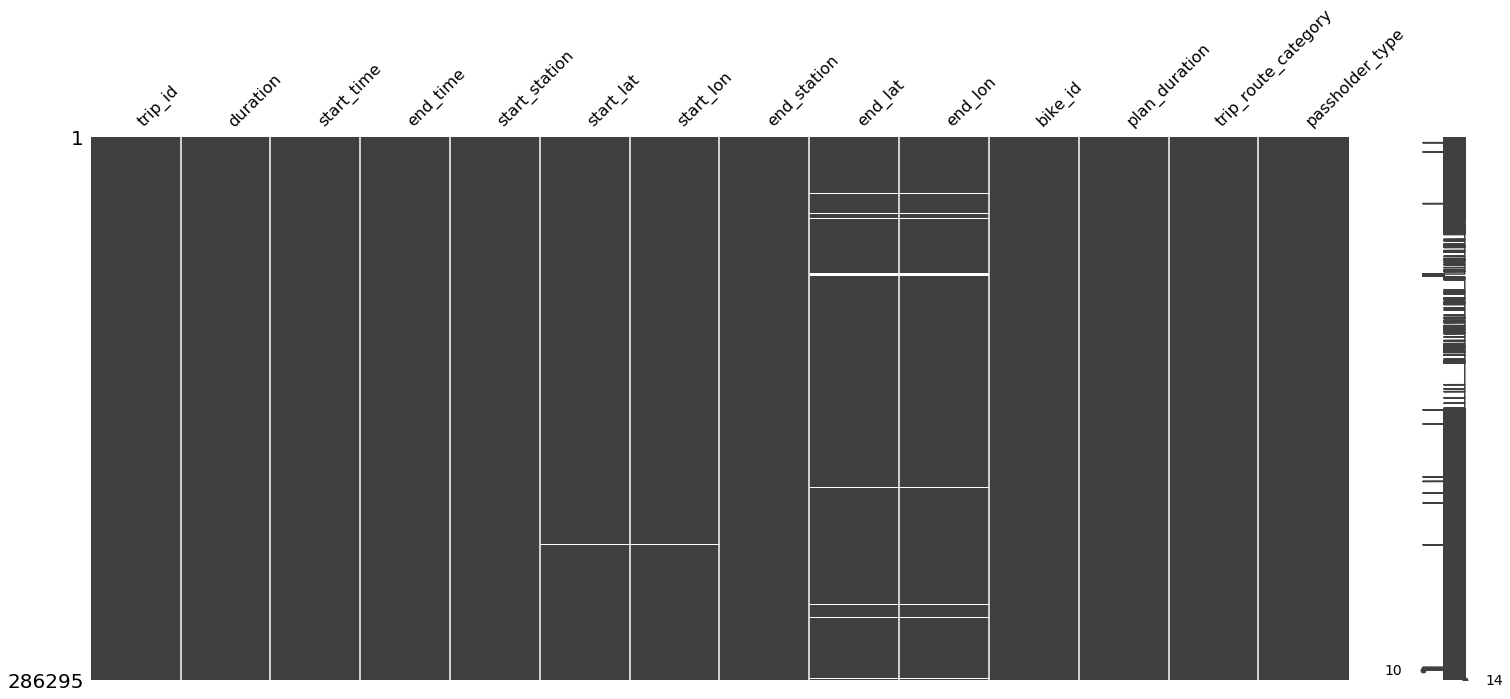

In [20]:
%matplotlib inline
msno.matrix(rides_df)

In [21]:
rides_df = rides_df.drop_na()

AttributeError: 'DataFrame' object has no attribute 'drop_na'